In [8]:
import pandas as pd
import numpy as np

In [9]:
dataframe = pd.read_csv('X_train_G3tdtEn.csv')
test_Dataframe = pd.read_csv('X_test_8skS2ey.csv')
data_Y = pd.read_csv('Y_train_2_XPXJDyy.csv')

df = dataframe.copy()

## change of the categorical data to numbers

list_uniqueLabel = []
list_col_object = []
list_dic_map = []
# Loop for that assign a each unique categorical value a number and after it reeplace the categorical value for this number
for col in df.columns:
    if df[col].dtypes == object:
        list_col_object.append(col)


for count in range(0,4):

    concate = pd.concat([dataframe[colum] for colum in list_col_object[(count*24):((count+1)*24)]])
    concate = pd.concat([test_Dataframe[columt] for columt in list_col_object[(count*24):((count+1)*24)]])
    concate = pd.concat([pd.Series([np.nan]),concate])

    list_uniqueLabel.append(concate.unique())

    # dictionary
    dic_map = {label : index for index, label in enumerate(list_uniqueLabel[-1])}
    
    # Replace the values in dataframe

    for colob in range(0,24):
        df[list_col_object[colob+count*24]] = df[list_col_object[colob+count*24]].map(dic_map)

    list_dic_map.append(dic_map.copy())
    dic_map.clear()


/var/folders/11/vh5hxzpd6kn7s0r70j_p9bd80000gn/T/ipykernel_42422/2266204275.py:1: DtypeWarning: Columns (21,22,23,24,69,70,71,72,93,94,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('X_train_G3tdtEn.csv')


In [10]:
# Reemplace the 0 in the converted columns to his true value NaN 
df[list_col_object] = df[list_col_object].replace(0,np.nan)

# Verification exact coincidence

exact_coincidence = (df['ID'] == data_Y['ID']).all()
print(exact_coincidence)

# we put out the columns that not contribute to the prediction

df = df.drop('ID',axis=1)
data_Y = data_Y.drop(['index','ID'], axis=1)

True


In [11]:
dataX = np.array(df)
dataY = np.array(data_Y)

print(dataX.shape)
print(dataY.shape)

print(np.sum(np.isnan(dataX)))

(92790, 145)
(92790, 1)
12384164


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Remplace the NaN values

constant_imputer = SimpleImputer(strategy='constant')
dataX_imp = constant_imputer.fit_transform(dataX)

# normalizacion 

scaler = MinMaxScaler(feature_range=(0, 1))
dataX_n = scaler.fit_transform(dataX_imp)

# Split of the data for validation set

training_input_t,val_input,training_output_t,val_output = train_test_split(dataX_n, data_Y, test_size=0.2)


In [13]:

# SMOTE tecnique (Syntetic geenration of data)

from imblearn.over_sampling import SMOTE

# Return to dataframe

df_train = pd.DataFrame(training_input_t,columns=df.columns)
datY_train = pd.DataFrame(training_output_t,columns=data_Y.columns)

# Aplication of SMOTE only in the training data (test is with the original values)

count_minoritary_class = len(datY_train[datY_train['fraud_flag'] == 1])
smote = SMOTE(sampling_strategy={1:(12*count_minoritary_class)}, random_state=42) # the {1:4} means have the class with label 1, 4 times, so increase 3 values

df_smote,data_y_smote = smote.fit_resample(df_train,datY_train)

# Print number each class
print('class distribution before SMOTE')
print(datY_train['fraud_flag'].value_counts())
print('\n')
print('class distribution after SMOTE')
print(data_y_smote['fraud_flag'].value_counts())

print(df_train.shape)
print(df_smote.shape)
# Conversion to array

dataX_a = np.array(df_smote)
dataY_a = np.array(data_y_smote)

# Determination of training data
training_input,training_output = dataX_a,dataY_a

class distribution before SMOTE
fraud_flag
0    73211
1     1021
Name: count, dtype: int64


class distribution after SMOTE
fraud_flag
0    73211
1    12252
Name: count, dtype: int64
(74232, 145)
(85463, 145)


In [14]:
import tensorflow as tf

# Function to improve the learning rate

def adapt_learning_rate(epoch):
    lr=0.001
    if epoch>100:
        lr=0.0001
    if epoch>200:
        lr=0.00005
    if epoch>240:
        lr=0.00001
    if epoch>700:
        lr=0.000005

    return lr

my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [15]:
# Neural Network

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

# Network

model = Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(145,)))
model.add(Dense(100,activation='relu'))
model.add(Dense(200,activation='tanh'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(250,activation='selu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(500,activation='elu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(250,activation='selu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(150,activation='relu'))
model.add(Dense(1,activation='sigmoid')) # Output

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               14600     
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 batch_normalization (Batch  (None, 200)               800       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 250)               50250     
                                                                 
 batch_normalization_1 (Bat  (None, 250)               1000      
 chNormalization)                                       

In [16]:
from sklearn.metrics import average_precision_score

# Define the metric average_precision as a personalised function
def average_precision(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.float64)

In [17]:
model.compile(optimizer='adam',
                loss='mse',
                metrics=[average_precision])

In [18]:
# Weights for the learning for each target label

weights = {0:1, 1:6} # 7 Label (1) have 100 times more importance in the learning than label (0)

In [19]:
history1 = model.fit(training_input,training_output,batch_size=600,epochs=250,
                    shuffle=True,callbacks=my_lr_scheduler,class_weight=weights,validation_data=(val_input,val_output))


Epoch 1/250
143/143 [==============================] - 3s 15ms/step - loss: 0.3854 - average_precision: 0.2839 - val_loss: 0.2318 - val_average_precision: 0.0673 - lr: 0.0010
Epoch 2/250
143/143 [==============================] - 2s 15ms/step - loss: 0.3331 - average_precision: 0.3690 - val_loss: 0.1154 - val_average_precision: 0.0598 - lr: 0.0010
Epoch 3/250
143/143 [==============================] - 2s 15ms/step - loss: 0.3143 - average_precision: 0.3978 - val_loss: 0.0815 - val_average_precision: 0.1049 - lr: 0.0010
Epoch 4/250
143/143 [==============================] - 2s 17ms/step - loss: 0.2980 - average_precision: 0.4270 - val_loss: 0.0370 - val_average_precision: 0.0909 - lr: 0.0010
Epoch 5/250
143/143 [==============================] - 2s 16ms/step - loss: 0.2894 - average_precision: 0.4504 - val_loss: 0.0426 - val_average_precision: 0.0797 - lr: 0.0010
Epoch 6/250
143/143 [==============================] - 2s 15ms/step - loss: 0.2790 - average_precision: 0.4682 - val_loss: 0.

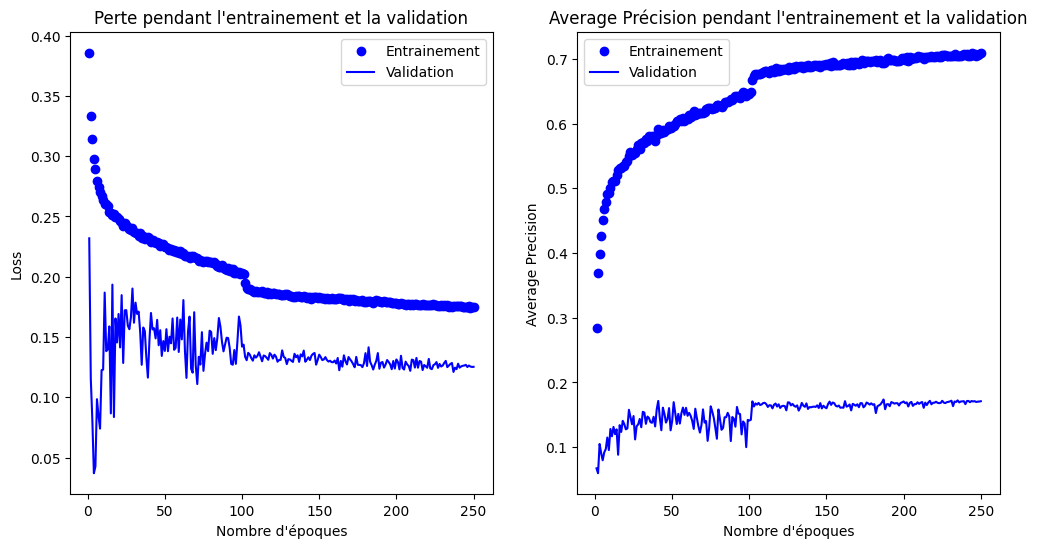

In [20]:
# Visualization of the model

import matplotlib.pyplot as plt

# plot fonction perte

loss=history1.history['loss']

val_loss = history1.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure(figsize=(12,6))


plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label = 'Entrainement')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Perte pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Loss')
plt.legend()

# plot precision du model

avp = history1.history['average_precision']
val_avp = history1.history['val_average_precision']

plt.subplot(1,2,2)
plt.plot(epochs,avp,'bo',label='Entrainement')
plt.plot(epochs, val_avp, 'b', label='Validation')
plt.title('Average Précision pendant l\'entrainement et la validation')
plt.xlabel('Nombre d\'époques')
plt.ylabel('Average Precision')
plt.legend()
plt.savefig('loss_accuracy_model.jpg')
plt.show()

TRATMENT OF THE TEST DATA

In [21]:
test_Dataframe = pd.read_csv('X_test_8skS2ey.csv')
test = test_Dataframe.copy()


# Loop for that assign a each unique categorical value a number and after it reeplace the categorical value for this number

for count_1 in range(0,4):

    # dictionary
    dic_map_1 = list_dic_map[count_1]

    # Replace the values in dataframe

    for colob_1 in range(0,24):
        test[list_col_object[colob_1+count_1*24]] = test[list_col_object[colob_1+count_1*24]].map(dic_map_1)


/var/folders/11/vh5hxzpd6kn7s0r70j_p9bd80000gn/T/ipykernel_42422/2728503367.py:1: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  test_Dataframe = pd.read_csv('X_test_8skS2ey.csv')


In [22]:
# Reemplace the 0 in the converted columns to his true value NaN
test[list_col_object] = test[list_col_object].replace(0,np.nan)

# we put out the columns that not contribute to the prediction
test = test.drop('ID',axis=1)

In [23]:
dataX = np.array(test)

print(dataX.shape)

print(np.sum(np.isnan(dataX)))

(23198, 145)
3095028


In [24]:
# Remplace the NaN values

constant_imputer = SimpleImputer(strategy='constant')
dataX_imp = constant_imputer.fit_transform(dataX)

# normalizacion

scaler = MinMaxScaler(feature_range=(0, 1))
dataX_test = scaler.fit_transform(dataX_imp)

PREDICTION AND GENERATION OF THE Y TEST

In [25]:
# Prediction

y_pred = model.predict(dataX_test)

counter_p = len([valor for valor in y_pred if valor > 0.5])
print('There are ',counter_p, ' labels (1) predicted')

Y_test = pd.DataFrame(np.column_stack([test_Dataframe['ID'],y_pred]),columns=['ID','fraud_flag'])
Y_test.to_csv('Y_test.csv', index=True,index_label='index')
print(y_pred)

725/725 [==============================] - 1s 864us/step
There are  312  labels (1) predicted
[[5.5513141e-04]
 [1.2932090e-05]
 [1.1131561e-06]
 ...
 [2.2995744e-06]
 [6.6243469e-05]
 [6.7451429e-06]]
